**ITSs**

In [46]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from pandas import read_csv, DataFrame
from tqdm import tqdm
from subprocess import call
from Bio.SeqIO import parse
from skbio.stats.composition import clr 


In [ ]:
pip install -U kaleido

In [47]:
def create_fasta(output, mearged_pike_out, dbpath):
    # Create fasta file 
    consensus = {}
    cons_conter = 0
    
    with open(f'{output}/all_consensus.fasta', 'w') as opn_fasta:
        for cons in mearged_pike_out.index:
    
            opn_fasta.write(f'>{cons_conter}\n{cons}\n')
            consensus[cons_conter] = cons
            cons_conter += 1
    
    return consensus
    
def run_blast(base, path):
    
    call(f'makeblastdb -in {base} -dbtype nucl', shell=True)
    call(f'blastn -num_threads 60  -outfmt "7 qseqid sseqid pident evalue qcovs bitscore" -query {path}/all_consensus.fasta  -db {base} -out {path}/blast_results.txt', shell=True)
 #   pass
def decode_tax(base) -> dict:
    
    # DB decoder 
    # Use db header format: Kingdom    Phylum    Class    Order    Family    Genus    Species
    
    base = parse(base, 'fasta')
    taxonomy_linage = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    tax_decoder = {}
    
    for line in tqdm(base):
        
        tax_decoder[line.id] = {}
        linage = line.description.split(';')
        linage[0] = linage[0].split()[1]
    
        for i in range(len(taxonomy_linage)):
            try:
                if taxonomy_linage[i] != 'Species':
                
                    tax_decoder[line.id][taxonomy_linage[i]] = linage[i]
                
                else:
                    #print(linage[i].split())
                    tax_decoder[line.id][taxonomy_linage[i]] = ' '.join(linage[i].split()[:2])
                  
            except:
                
                tax_decoder[line.id][taxonomy_linage[i]] = 'NA'
    
    return tax_decoder

def parse_blast(path, 
                base, 
                data_tax, 
                consensus, 
                identity_filter, 
                cov_lim, 
                evalue_filter):
    
    # parser of blast table
    
    blast_header = ['qseqid',
                    'sseqid', 
                    'pident',
                    'evalue',
                    'qcovs', 
                    'bitscore']
    
    blasting_results = {}
    opn_blast = read_csv(f'{path}/blast_results.txt', sep='\t', comment='#', header=None, names=blast_header)
    
    for i in tqdm(opn_blast['qseqid'].unique()):
        
        blast_subset = opn_blast[opn_blast["qseqid"] == i]
        blast_subset = blast_subset[blast_subset['pident'] >= identity_filter]
        blast_subset = blast_subset[blast_subset['evalue'] <= evalue_filter]
        blast_subset = blast_subset[blast_subset['qcovs'] >= cov_lim]

        #blast_subset = blast_subset.sort_values(by='evalue')
        #blast_subset = blast_subset.sort_values(by='pident')[::-1]
        #blast_subset = blast_subset.sort_values(by='pident')[::-1]
        blast_subset = blast_subset.sort_values(by='evalue')

        if len(blast_subset['sseqid'].values) == 0:
            continue
            
        subject = blast_subset['sseqid'].values[0]
        blasting_results[consensus[i]] = data_tax[subject]
        
    blasting_results_df = DataFrame(blasting_results).T
    
    return blasting_results_df
    
def processing_data_tax(data_tax):

    data_tax_df = DataFrame(data_tax).T.fillna(0)
    # Add pseudocunt
    # data_tax_df = data_tax_df + 1
    data_tax_df = data_tax_df.assign(m=data_tax_df.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(data_tax_df.columns)]

    return  data_tax_df
    
def get_taxonomy(data_tax, 
                 blasting_results_df, 
                 mearged_pike_out, 
                 tax_level='OTU'):
    
    data_tax = {}
    avs = np.intersect1d(blasting_results_df.index, mearged_pike_out.index)
    count = 1
    OTU_decoder  = {'Seq': [], 'OTU_name' : []}
    
    for av in tqdm(avs):

        if tax_level == 'OTU':
        
            tax = f'OTU_{count}_{blasting_results_df["Species"][av]}'
        else:    
            tax = blasting_results_df[tax_level][av]
        count += 1
        OTU_decoder['Seq'].append(av)
        OTU_decoder['OTU_name'].append(tax)
        if tax == 'nan':
            
            tax = 'No Fungi'

        if tax not in data_tax.keys():
    
            data_tax[tax] = {col: 0 for col in mearged_pike_out.columns} 
        
        for col in mearged_pike_out.columns:
           
            data_tax[tax][col] += mearged_pike_out[col][av]
    
    data_tax_df = processing_data_tax(data_tax)
    
    return data_tax_df, OTU_decoder
    

def filter_data(output, 
                dbpath,
                mearged_pike_out,
                taxonomy_level, 
                identity_filter=0, 
                cov_lim=0, 
                evalue_filter=1e-10):

    # Creating output directory
    try:
        
        os.mkdir(output)
        
    except FileExistsError:
        
        print('The output directory already exists!')
        
    consensus = create_fasta(output, mearged_pike_out, dbpath)
    run_blast(dbpath, output)
    data_tax = decode_tax(dbpath)
    blasting_results_df = parse_blast(output, 
                                      dbpath, 
                                      data_tax, 
                                      consensus, 
                                      identity_filter, 
                                      cov_lim, 
                                      evalue_filter)

  #  mearged_pike_out = filter_av(mearged_pike_out, prevalence, detection, slice)
    data_tax_df, OTU_decoder = get_taxonomy(data_tax, 
                                            blasting_results_df, 
                                            mearged_pike_out,
                                            taxonomy_level)

    data_tax_df = data_tax_df[mearged_pike_out.columns]
    for col in data_tax_df.columns:
        
        data_tax_df[col] = data_tax_df[col] / np.sum(data_tax_df[col].values)
    
    data_tax_df = data_tax_df.fillna(0)[mearged_pike_out.columns]   
    data_tax_df = data_tax_df.assign(m=data_tax_df.mean(axis=1)).sort_values('m').drop('m', axis=1)


    return data_tax_df, data_tax, blasting_results_df, DataFrame(OTU_decoder)

In [5]:
import random
def get_color(obj_dict):
    
    color = ''
    
    while color not in obj_dict.values() and color == '':
        
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    
    return color

MERGING ALL TABLES INTO ONE

SINGLE MODE

In [48]:
mearged_otu_table = []

for amplicon_type in ['_100000_reads', '_10000_reads', '_1000_reads',
                      '_200_reads', '_250_reads', '_30000_reads', '_3000_reads', '_300_reads',
                      '_50000_reads', '_5000_reads', '_500_reads',]:
    
    for sample in listdir(f'/mnt/AsusShareI2/RUNS/runs-sonec/pike_single_mode/pike_ITS2_all/pike_ITS2_trimmed{amplicon_type}/results/'):
        opn_res = read_csv(f'/mnt/AsusShareI2/RUNS/runs-sonec/pike_single_mode/pike_ITS2_all/pike_ITS2_trimmed{amplicon_type}/results/{sample}/results.tsv', sep='\t', index_col=0)
        if 'Count' in opn_res.columns:
            count = 0
            mearged_otu_table.append(DataFrame(data=opn_res['Count'].tolist(), index=opn_res.index, columns=[sample + amplicon_type]))
            with open(f'/mnt/AsusShareI2/RUNS/runs-sonec/pike_single_mode/pike_ITS2_all/pike_ITS2_trimmed{amplicon_type}/{sample}.fasta', 'w') as opn_fasta:
                for line in opn_res.index:
                    opn_fasta.write(f'>{count}_{opn_res["Count"][line]}\n{line}\n')
                    count += 1
        else:
            print(f'Столбец "Count" отсутствует в результате для образца {sample + amplicon_type}')

mearged_otu_table = pd.concat(mearged_otu_table, axis=1).fillna(0)
mearged_otu_table = mearged_otu_table.reindex(sorted(mearged_otu_table.columns), axis=1)
mearged_otu_table.to_csv('single_ITS_2_merged_otu_table_all_samples_all_reads_new_db.csv')

POOL MODE

In [57]:
mearged_otu_table = []

for amplicon_type in ['_100000_reads', '_10000_reads', '_1000_reads',
                      '_200_reads', '_250_reads', '_30000_reads', '_3000_reads', '_300_reads',
                      '_50000_reads', '_5000_reads', '_500_reads',]:
    
    for sample in listdir(f'/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/ITS/ITS_full/pool_ITS_full_k6{amplicon_type}/results/'):
        opn_res = read_csv(f'/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/ITS/ITS_full/pool_ITS_full_k6{amplicon_type}/results/{sample}/results.tsv', sep='\t', index_col=0)
        if 'Count' in opn_res.columns:
            count = 0
            mearged_otu_table.append(DataFrame(data=opn_res['Count'].tolist(), index=opn_res.index, columns=[sample + amplicon_type]))
            with open(f'/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/ITS/ITS_full/pool_ITS_full_k6{amplicon_type}/{sample}.fasta', 'w') as opn_fasta:
                for line in opn_res.index:
                    opn_fasta.write(f'>{count}_{opn_res["Count"][line]}\n{line}\n')
                    count += 1
        else:
            print(f'Столбец "Count" отсутствует в результате для образца {sample + amplicon_type}')

mearged_otu_table = pd.concat(mearged_otu_table, axis=1).fillna(0)
mearged_otu_table = mearged_otu_table.reindex(sorted(mearged_otu_table.columns), axis=1)
mearged_otu_table.to_csv('pool_ITS_12_merged_otu_table_all_samples_all_reads_new_db.csv')

In [ ]:
mearged_otu_table.head(10)

**WORKING WITH SILVA AND BLAST**

**OTU**

In [43]:
output = f'/mnt/AsusShareI2/RUNS/runs-sonec/pike_single_mode/pike_ITS2_all/pike_ITS2_trimmed{amplicon_type}/TAXONOMY'
#dbpath = '/mnt/AsusShareI2/RUNS/runs-sonec/SILVA_138.1_SSURef_NR99_tax_silva.fasta'
#dbpath = '/mnt/AsusShareI2/RUNS/runs-sonec/dada_unite.fasta'
dbpath = '/mnt/AsusShareI2/RUNS/runs-sonec/unite_04.04.2024.fasta'
#taxonomy_level = 'Genus'
#taxonomy_level = 'Species'
taxonomy_level = 'OTU'

data_tax_df, data_tax, blasting_results_df, OTU_decoder = filter_data(output, 
                                                                     dbpath,
                                                                     mearged_otu_table,
                                                                     taxonomy_level, 
                                                                     identity_filter=0, 
                                                                     cov_lim=0, 
                                                                     evalue_filter=1e-10)
data_tax_df.to_csv('single_ITS_2_data_tax_df_OTU_new_db.csv', sep='\t')

The output directory already exists!


Building a new DB, current time: 08/20/2024 12:39:19
New DB name:   /mnt/AsusShareI2/RUNS/runs-sonec/unite_04.04.2024.fasta
New DB title:  /mnt/AsusShareI2/RUNS/runs-sonec/unite_04.04.2024.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/AsusShareI2/RUNS/runs-sonec/unite_04.04.2024.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 93085 sequences in 3.35746 seconds.




93085it [00:00, 145040.91it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:00<00:00, 3974.30it/s]


In [60]:
output = f'/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/ITS/ITS_full/pool_ITS_full_k6{amplicon_type}/TAXONOMY'
#dbpath = '/mnt/AsusShareI2/RUNS/runs-sonec/SILVA_138.1_SSURef_NR99_tax_silva.fasta'
#dbpath = '/mnt/AsusShareI2/RUNS/runs-sonec/dada_unite.fasta'
dbpath = '/mnt/AsusShareI2/RUNS/runs-sonec/unite_04.04.2024.fasta'
#taxonomy_level = 'Genus'
taxonomy_level = 'Species'
#taxonomy_level = 'OTU'

data_tax_df, data_tax, blasting_results_df, OTU_decoder = filter_data(output, 
                                                                     dbpath,
                                                                     mearged_otu_table,
                                                                     taxonomy_level, 
                                                                     identity_filter=0, 
                                                                     cov_lim=0, 
                                                                     evalue_filter=1e-10)
data_tax_df.to_csv('pool_ITS_12_data_tax_df_species_new_db.csv', sep='\t')

The output directory already exists!


Building a new DB, current time: 08/22/2024 14:19:17
New DB name:   /mnt/AsusShareI2/RUNS/runs-sonec/unite_04.04.2024.fasta
New DB title:  /mnt/AsusShareI2/RUNS/runs-sonec/unite_04.04.2024.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/AsusShareI2/RUNS/runs-sonec/unite_04.04.2024.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 93085 sequences in 2.34841 seconds.




93085it [00:01, 78962.84it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 1747.22it/s]


In [ ]:
OTU_decoder.to_csv('OTU_decoder_ITS_full_species_new_DADA.csv', sep = '\t')

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np
import re
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns

In [26]:
data_tax_df.head(10)
number_mapping = {col: int(col.split('_')[-2]) for col in data_tax_df.columns}
sorted_columns = sorted(number_mapping, key=number_mapping.get)
data_tax_df_sorted = data_tax_df[sorted_columns]

In [27]:
def get_color(obj_dict):
    color = ''
    while color not in obj_dict.values() and color == '':  
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    return color
color_collection = {}
for i in data_tax_df_sorted.index:
    color_collection[i] = get_color(color_collection)

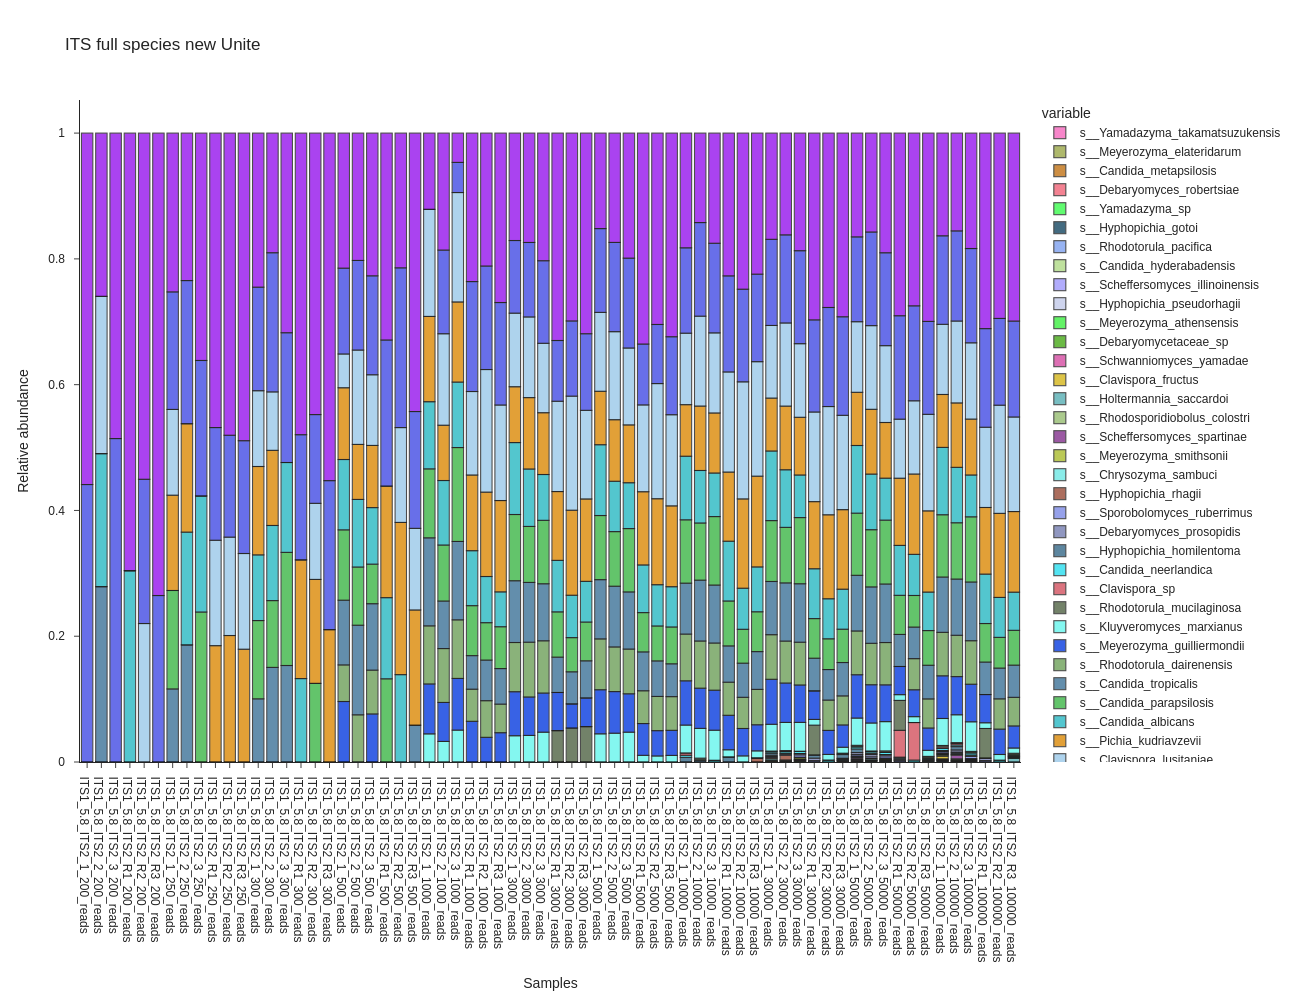

In [28]:
fig = px.bar(data_tax_df_sorted.T, 
             y=data_tax_df_sorted.index, 
             x=data_tax_df_sorted.columns,
             width=1300, 
             height=1000, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white', title = 'ITS full species new Unite',
             color_discrete_map=color_collection)
#fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

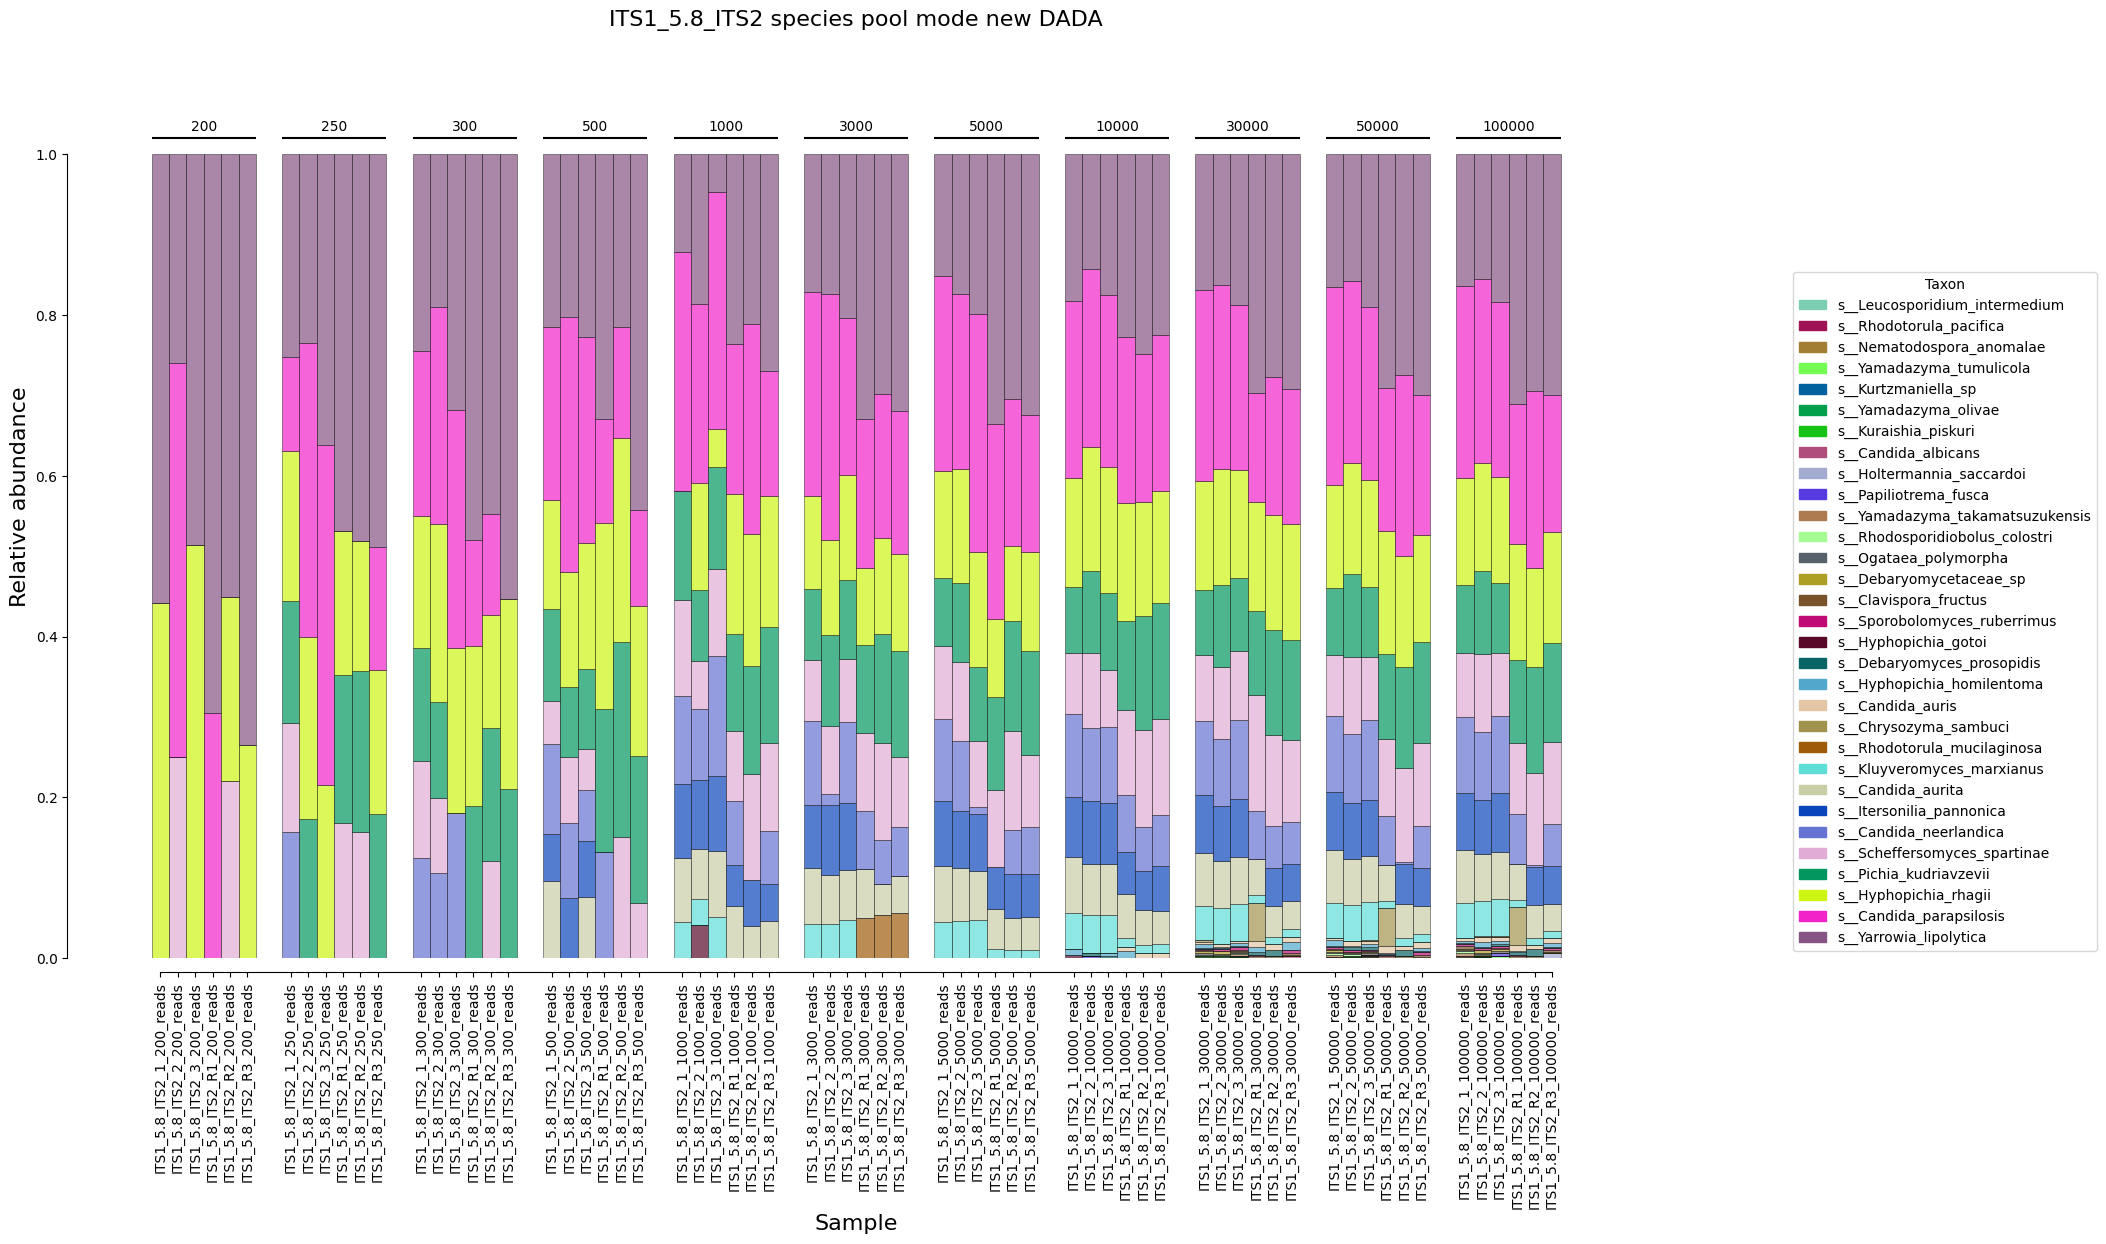

In [18]:
sample_coord = 0
sample_coords_list = []
counter = 0
width = 1
bottom = 0
#plt.rcParams["figure.figsize"] = (12, 12)
plt.figure(figsize=(20, 12))
for sample in data_tax_df_sorted.columns:
    for genus in data_tax_df_sorted.index:
        plt.bar(sample_coord, 
                    data_tax_df_sorted[sample][genus], 
                    width,  
                    bottom=bottom,
                    label = genus,
                    edgecolor='black',
                    linewidth=0.4, 
                    alpha=0.7,
                    color=color_collection[genus])
        bottom += data_tax_df_sorted[sample][genus]
    sample_coords_list.append(sample_coord)
    sample_coord += 1
    counter +=1
    if counter % 6 == 0:
        sample_coords_list.append(sample_coord)
        sample_coord += 1.5
        counter = 0
    bottom = 0

new_list = [item for index, item in enumerate(sample_coords_list) if (index + 1) % 7 != 0]
plt.xticks(ticks = new_list, labels = data_tax_df_sorted.columns, rotation = 'vertical')
sns.despine(offset=10, trim=True)
plt.xlabel("Sample", fontsize = 16)
plt.ylim(top=1.15)
new_list = [item for index, item in enumerate(sample_coords_list) if (index + 1) % 7 != 0]
plt.xticks(ticks = new_list, labels = data_tax_df_sorted.columns, rotation = 'vertical')

y = 1.02 
str_length = 6  
gap_btw = 1.5  
max_x = 102.5 
x_start = -0.5
x_values = []
hline_labels = ['200','250','300','500','1000','3000','5000','10000','30000','50000','100000']

while x_start <= max_x:
    x_values.append((x_start, x_start + str_length))  
    x_start += str_length + gap_btw 

for (start, end), labels in zip(x_values, hline_labels):
    plt.hlines(y, start, end, color='black')
    plt.text((start + end) / 2, y + 0.01, labels, ha='center')
patches = [mpatches.Patch(color=color, label=genus) for genus, color in color_collection.items()]
plt.ylabel("Relative abundance", fontsize = 16)
plt.legend(handles = patches,title='Taxon',bbox_to_anchor = (1.1,0.75))
plt.title('ITS1_5.8_ITS2 species pool mode new DADA', loc = 'center', fontsize = 16)
plt.savefig("ITS_full_species_POOL_new_DADA.pdf",format="pdf", bbox_inches="tight")
plt.savefig("ITS_full_species_POOL_new_DADA.png", dpi=800, format="png", bbox_inches='tight')

In [19]:
OTU_decoder

,Seq,OTU_name
0,AAAGTTCAGCAGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...,s__Yarrowia_lipolytica
1,AAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAAATGTCGTG...,s__Scheffersomyces_spartinae
2,AAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAAATGTCGTG...,s__Scheffersomyces_spartinae
3,AAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAATA...,s__Sporobolomyces_ruberrimus
4,AAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAATA...,s__Candida_parapsilosis
...,...,...
585,TAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAATA...,s__Candida_parapsilosis
586,TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGATCTAATCTTAAA...,s__Sporobolomyces_ruberrimus
587,TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCGAGCTTTTTG...,s__Pichia_kudriavzevii
588,TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCGAGCTTTTTG...,s__Pichia_kudriavzevii


In [21]:
OTU_decoder.to_csv('OTU_decoder_ITS_full_species_new_DADA.csv')

In [ ]:
data_tax_no0_rows = (data_tax_df !=0).sum()
result = pd.DataFrame(data_tax_no0_rows).transpose()
result.head(10)
#result.index = ['OTU_count_nonzero']
#result.to_csv('OTU_count_nonzero.csv',sep='\t')

In [ ]:
result_long = result.melt(var_name='column', value_name='Genus_count_nonzero')
result_long

In [ ]:
result_long['sample_name'] = result_long['column'].str.extract(r'(ITS1_(?:R)?\d+)_\d+_reads')
result_long
#result_long.to_csv('result_long_test.csv',sep='\t')

In [ ]:
result_long['number_of_reads'] = result_long['column'].str.extract(r'ITS1_(?:R)?\d+_(\d+)_reads')
result_long.drop('column', axis=1, inplace=True)
result_long.fillna(0)
result_long['number_of_reads'] = result_long['number_of_reads'].astype('int')
result_long

In [ ]:
result_long=result_long.sort_values('number_of_reads',ascending=True)

In [ ]:
result_long
result_long.to_csv('pool_k6_ITS_1_genus_count_long_table.csv', sep='\t')

**PLOTTING FROM RESULT_LONG DF( OPTIMAL)**

In [ ]:
fig, ax = plt.subplots()
for sample in result_long['sample_name'].unique():
    subset = result_long[result_long['sample_name'] == sample]
    ax.plot(subset['number_of_reads'], subset['OTU_count_nonzero'], marker='o', linestyle='-', label=sample)

ax.set_xlabel('Number of reads')
ax.set_ylabel('Count')
ax.set_title('OTU')
ax.set_ylim(-1, 35)
ax.set_xscale('log')
#ax.xaxis.set_ticks(result_melted["number_of_reads"])
ax.legend()
plt.show()
#plt.savefig('OTU_V3_V4.png')

In [ ]:
samples = pd.Series([col.rsplit('_', 2)[0] for col in result.columns]).drop_duplicates().tolist()
samples

In [ ]:
reads = pd.Series([col.split('_')[-2] for col in result.columns]).drop_duplicates().tolist()
reads.sort()
reads

TESTING RESHAPING DF ON DUMMY DATA

In [ ]:
# Assuming your initial dataframe is named df
data = {
    'V3_V4_1_100_reads': [10],
    'V3_V4_2_100_reads': [15],
    'V3_V4_3_100_reads': [20],
    'V3_V4_1_500_reads': [30],
    'V3_V4_2_500_reads': [30],
    'V3_V4_3_500_reads': [35]
}

df = pd.DataFrame(data)

# Melt the dataframe to go from wide to long format
df_long = df.melt(var_name='column', value_name='OTU_count_nonzero')

In [ ]:
df

In [ ]:
df_long

In [ ]:
# Extract sample names and number of reads
df_long['sample_name'] = df_long['column'].str.extract(r'(V3_V4_\d+)_\d+_reads')
df_long

In [ ]:
df_long['number_of_reads'] = df_long['column'].str.extract(r'V3_V4_\d+_(\d+)_reads')
df_long

In [ ]:
# Drop the original column names as they are no longer needed
df_long.drop('column', axis=1, inplace=True)
df_long

In [ ]:
# Pivot the table to get the desired format
df_pivot = df_long.pivot(index='number_of_reads', columns='sample_name', values='OTU_count_nonzero')
df_pivot

In [ ]:
# Reset the index to get number_of_reads as a column
df_final = df_pivot.reset_index()
df_final

In [ ]:
# Optionally, sort by number_of_reads if needed
df_final.columns

In [ ]:
df_final.columns.name = None
# Print the final dataframe
print(df_final)

**GENUS**

In [ ]:
Color_collection = {}

for i in data_tax_df.index:
    
    Color_collection[i] = get_color(Color_collection)

In [ ]:
import plotly.express as px
import plotly.subplots as sp

fig = px.bar(data_tax_df.T, 
             x=data_tax_df.columns, 
             y=data_tax_df.index,
             width=1500, 
             height=900, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',
             color_discrete_map=Color_collection)
fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.update_xaxes(range=[-1, len(mearged_otu_table.T)+0.2], autorangeoptions_clipmax=len(data_tax_df.T))

#fig.update_layout(showlegend=False)
#os.mkdir("VIZ")
fig.write_image(f"VIZ/16S_{taxonomy_level}.pdf")
fig.write_image(f"VIZ/16S_{taxonomy_level}.png", scale=5)
fig.show()